In [258]:
# 这是我电脑自己环境的问题，你们不用运行
import sys
sys.path
sys.path.remove('C:\\Users\\Lenovo\\AppData\\Roaming\\Python\\Python38\\site-packages')

ValueError: list.remove(x): x not in list

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
from math import *
import random
from scipy.optimize import fmin

colors = ["grey", "brown", "orange", "olive", "green", "cyan",
              "blue", "purple", "pink", "red"]

# colors = ['black', 'gray', 'firebrick', 'red', 'chocolate',
#               'orange', 'peru', 'darkgoldenrod', 'olive',
#               'yellow', 'green', 'turquoise', 'deepskyblue',
#               'blue', 'violet', 'purple', 'deeppink']

## 0. LDA, DSC, dDSC, GONG Function

In [3]:
# 返回质心向量
def getTwoClassMean(c0, c1):
    """
    get the mean vector of two class
    """
    mean0_vectors = np.mean(c0, axis=0)
    mean1_vectors = np.mean(c1, axis=0)
    return mean0_vectors, mean1_vectors
# 返回SW SB
def getClassScatterMatrix(c0, c1):
    """
    input two class data
    return the scatter for each class
    and with-in sc_mat and between sc_mat
    """
    mean0_vectors, mean1_vectors = getTwoClassMean(c0, c1)
    num0 = c0.shape[0]
    num1 = c1.shape[0]
    dim = c0.shape[1]
    class0_sc_mat = np.zeros((dim, dim))
    mv = mean0_vectors.reshape((dim, 1))
    for row in c0:
        row = row.reshape((dim, 1))
        class0_sc_mat += (row-mv).dot((row-mv).T)
    class1_sc_mat = np.zeros((dim, dim))
    mv = mean1_vectors.reshape((dim, 1))
    for row in c1:
        row = row.reshape((dim, 1))
        class1_sc_mat += (row-mv).dot((row-mv).T)
    S_W = class0_sc_mat + class1_sc_mat
    c = np.concatenate((c0, c1))  # Vertical stacking, default axis is 0
    overall_mean = np.mean(c, axis=0)
    overall_mean = overall_mean.reshape((dim, 1))
    mean_vec = mean0_vectors.reshape((dim, 1))
    S_B = np.zeros((dim, dim))
    S_B += num0 * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    mean_vec = mean1_vectors.reshape((dim, 1))
    S_B += num1 * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    return class0_sc_mat, class1_sc_mat, S_W, S_B


# 返回LDA目标函数在该投影下的值
def getLDAValue(S_W, S_B, w):
    result_cost = 1.0 * w.T.dot(S_B).dot(w) / w.T.dot(S_W).dot(w)
    return result_cost


def lda(c0, c1):
    """
    type is ndarray
    shape like (200,2) and 200 is the number of samples and 2 is the number of features
    pass two class data to the function
    return the Eigenvectors using LDA
    the solve method is Eigenvalue Decomposition
    """
    # get the basic information
    dim = c0.shape[1]  # the dim is the number of features, for instance, the dim of iris is 4
    c = np.concatenate((c0, c1))  # Vertical stacking, default axis is 0
    overall_mean = np.mean(c, axis=0)  # the overall_mean of the samples
    # print("overall_mean: ", overall_mean)
    num0 = c0.shape[0]  # the number of class-0
    num1 = c1.shape[0]  # the number of class-1

    # Computing the mean vectors
    mean0_vectors = np.mean(c0, axis=0)
    mean1_vectors = np.mean(c1, axis=0)
    S_W = np.zeros((dim, dim))
    class0_sc_mat = np.zeros((dim, dim))
    mv = mean0_vectors.reshape(dim, 1)
    # print("mv: ", mv)
    for row in c0:
        row = row.reshape(dim, 1)
        # print("row-mv: \n", row-mv)
        class0_sc_mat += (row-mv).dot((row-mv).T)
        # print("class0_sc_mat: ", class0_sc_mat)
    S_W += class0_sc_mat
    # print("within-class Scatter Matrix: \n", S_W)

    # for class1, al S_W1
    class1_sc_mat = np.zeros((dim, dim))
    mv = mean1_vectors.reshape((dim, 1))
    # print("mv: ", mv)
    for row in c1:
        row = row.reshape(dim, 1)
        class1_sc_mat += (row-mv).dot((row-mv).T)
        
    
    S_W += class1_sc_mat
    # print("within-class Scatter Matrix: \n", S_W)

    # Between-class scatter matrix S_B
    S_B = np.zeros((dim, dim))
    # print("overall_mean: ", overall_mean)
    overall_mean = overall_mean.reshape(dim, 1)
    mean_vec = mean0_vectors.reshape(dim, 1)
    S_B += num0*(mean_vec-overall_mean).dot((mean_vec-overall_mean).T)
    mean_vec = mean1_vectors.reshape(dim, 1)
    S_B += num1*(mean_vec-overall_mean).dot((mean_vec-overall_mean).T)
    # print("between-class Scatter Matrix: \n", S_B)

    eig_vals, eig_vecs = np.linalg.eig(np.linalg.pinv(S_W).dot(S_B))
    # for i in range(len(eig_vals)):
    #     eigvec_sc = eig_vecs[:, i].reshape(dim, 1)
    #     print("\nEigenvector {}: \n{}".format(i+1, eigvec_sc.real))
    #     print("Eigenvalue {:}: {:.2e}".format(i+1, eig_vals[i].real))

    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]


    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)


    return [i[1] for i in eig_pairs]


In [4]:
def get_distance_to_point(P1, P2):

    dx = abs(P1[0] - P2[0])
    dy = abs(P1[1] - P2[1])
    return math.sqrt(dx * dx + dy * dy)


# 计算一个点的GONG值，即所定义的set中与自己同类别所占的比例
def cal_one_point_GONG(Points, Label, i):
    omega = 0
    same_indicator = 0
    tot_num = Points.shape[0]
    for j in range(tot_num):
        if j == i:
            continue
        flag = True
        intermediary_point = 0.35 * Points[j] + 0.65 * Points[i]
        int2j_dist = get_distance_to_point(intermediary_point, Points[j])
        for k in range(tot_num):
            if k == i:
                continue
            dist = get_distance_to_point(intermediary_point, Points[k])
            if dist < int2j_dist:
                flag = False
                break
        if flag == False:
            continue
        omega += 1
        if Label[i] == Label[j]:
            same_indicator += 1
    if omega == 0:
        return 0
    return same_indicator/omega


# 计算某个类的GONG值
def get_label_GONG(Points, Label, lab):
    GONG_list = []
    tot_num = Points.shape[0]
    for i in range(tot_num):
        GONG_list.append(cal_one_point_GONG(Points, Label, i))
    GONG_list = np.array(GONG_list)
    return np.mean(GONG_list[Label == lab])

# 返回每个点的GONG值
def getGONGSepList(Points, Label):
    gongSepList = []
    tot_num = Points.shape[0]
    for i in range(tot_num):
        gongSepList.append(cal_one_point_GONG(Points, Label, i))
    return gongSepList


# 计算一个投影的GONG
def get_GONG_value(data, Label, evaluation):
    if evaluation == "Silhouette Coefficient":
        return metrics.silhouette_score(Points, Label)
    answer = 0
    for lab in set(label):
        answer += get_label_GONG(data,label,lab) * len(label[label == lab]) / len(label)
    return answer
    
    
def get_weighted_GONG(data, label, proj_set, proj_set_labels):
    """
    计算整个图的加权GONG值
    输入：原始数据data，label，投影集projection_set
    data和一个投影平面projection_set[i],可以组成投影后的data_
    对于每个类：
    计算这个类在所有投影中的GONG
    取最大值，作为这个类的GONG
    最终对每个类的GONG加权，得到整个图的加权GONG
    """
    proj_num = len(proj_set)
    
    label_count = {}
    GONG = []# GONG[i][j] 代表：在投影i上，第j个类的GONG值
    for i in range(proj_num):
        proj = proj_set[i]
        proj_label = proj_set_labels[i]
        GONG_list = {}

        data_0, data_1, data_, label_ = project_on_merged_vectors(data, label, set(proj_label), proj[0], proj[1])
        
        # 计算该投影下每一个类的GONG
        for lab in set(label_): 
            GONG_list[lab] = get_label_GONG(data_,label_,lab)
            label_count[lab] = len(label[label==lab])
            
        print(GONG_list)
        # 存入GONG
        GONG.append(GONG_list)
        
    label_GONG = {}
    for GONG_list in GONG:
        for key in GONG_list:
            if key not in label_GONG:
                label_GONG[key] = GONG_list[key]
            else:
                label_GONG[key] = max(label_GONG[key], GONG_list[key])
            
    print('-------')
    print(label_GONG)
    print(label_count)
    weighted_GONG = 0 
    
    cnt = 0
    for key in label_GONG:
        weighted_GONG += label_GONG[key] * label_count[key]
        cnt += label_count[key]

    weighted_GONG /= cnt
    return weighted_GONG

## Generate 3D Dataset

In [247]:
import numpy as np

def generate_data_sets(n_samples=50, centers=9, n_features=3, mean_step = 5, cov_step = 120):

    newX = np.array([])
    for i in range(centers):
        mean = np.random.randint(40, 100, size=n_features)
        mat = np.random.randint(10, 22, (n_features, n_features))
        mean += mean_step
        mat += cov_step
        cov = np.cov(mat)
        cov = np.ceil(cov)
        cov = abs(cov)
        new_x = np.random.multivariate_normal(mean, cov, (n_samples), 'raise')
        # print("newX",newX)
        # print("new_x",new_x)
        newX = list(newX)
        new_x = list(new_x)
        newX.extend(new_x)
        newX = np.array(newX)
    print(newX.shape)

    y = []
    for i in range(centers):
        for j in range(n_samples):
            y.append(i)
    y = np.array(y)
    return newX,y


(450, 2)


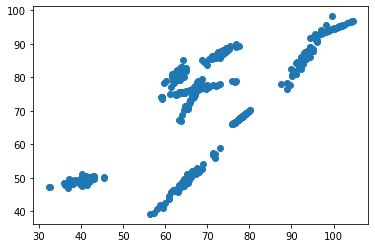

In [257]:
x1, y1 = generate_data_sets(50,9,2,0,0)
plt.scatter(x1[:,0],x1[:,1])

In [249]:
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D

X, y = generate_data_sets(n_samples=50, centers=5, n_features=6)


# ax = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
# #  将数据点分成三部分画，在颜色上有区分度
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)  # 绘制数据点

# ax.set_zlabel('Z')  # 坐标轴
# ax.set_ylabel('Y')
# ax.set_xlabel('X')
# plt.show()

ValueError: covariance is not positive-semidefinite.

## 1. Load and preprocess data

In [142]:
def read_data_from_file(filename):
    """
    :param filename: the data file, the format is class_label, dim0, dim1, ...
    :return: data and label
    """
    newfilename = './Data/' + filename  # because my data is in the Data folder
    data = []
    with open(newfilename, 'r') as f:
        for line in f:
            data.append(list(eval(line)))
    data = np.array(data)
    dim = data.shape[1]
    return data[:, 1:dim], data[:, 0]


# # 重新编排label为0, 1, 2,...
def get_label_right(label):
    class_label = list(set(label))
    label_dict = {}
    re_label = 0
    for it in class_label:
        label_dict[it] = re_label
        re_label += 1
    new_label = []
    for it in label:
        new_label.append(label_dict[it])
    return np.array(new_label)

In [305]:
#2个类的文件都要踢出来
path = r'.\Data'
dirs = os.listdir(path)
for fname in dirs:
    data, label = read_data_from_file(fname)
    # if(len(set(label)) == 2):
    print(fname, len(set(label)))

abalone_origClassLabels.csv 28
balance-scale.csv 3
bbdm13_origClassLabels.csv 5
boston_origClassLabels.csv 3
breast-cancer-wisconsin_origClassLabels.csv 2
breast_cancer.csv 2
cars03Cropped_d1_origClassLabels..csv 2
cars03Cropped_d1_origClassLabels.csv 2
cars03Cropped_d3_origClassLabels.csv 12
cereal_origClassLabels.csv 7
cmc.csv 3
combined_scale.csv 3
Connectionist_Bench_Vowel Recognition_Deterding_Data.csv 11
dermatology.csv 6
digits5_8.csv 5
ecoliproteins.csv 8
efashion_origClassLabels.csv 8
fisheries_clusteredByEscapementTarget.csv 11
fisheries_clusteredByHarvestRule.csv 11
ForestTypes.csv 4
hayes-roth.csv 3
Hill_Valley_with_noise_Testing.csv 2
hiv.csv 6
interleaved_100_200_10d_0_notcramped_notrotated.csv 10
interleaved_100_200_10d_25_cramped_rotated.csv 10
interleaved_100_200_15d_0_notcramped_notrotated.csv 15
interleaved_100_200_15d_25_cramped_rotated.csv 15
interleaved_100_200_4d_0_notcramped_notrotated.csv 4
interleaved_100_200_4d_25_cramped_rotated.csv 4
interleaved_100_200_5d_

In [323]:
# Change the following two lines to fit your data
fname = "cereal_origClassLabels.csv"  # the class data file
data, label = read_data_from_file(fname)
# data, label = X, y
label = get_label_right(label)
label = np.array(list(map(int, label)))
print(data.shape)
print(label)

(77, 12)
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6
 6 6 6]


## 2. Calculate the vector

In [307]:
#？
# 确保该向量方向是对的

def get_right_direction(vec, last_axis):
    if np.dot(vec, last_axis) < 0:
        return -vec
    return vec


def normalize(v):
        return v / np.linalg.norm(v)


# 第一步：寻找LDA下的最佳discriminative vector
def get_optimal_vector_from_lda(c0, c1):
    discriminating_vectors = lda(c0, c1)
    opt_vec = np.real(discriminating_vectors[0])  # ndarray
    return opt_vec


#？last_axis
# 寻找每两个类之间的最佳投影向量  (c0,c1):vector
def get_between_class_opt_vec(data, label):
    """
    :param data: the input data
    :param label: The label of the data
    :return: the optimal discriminant vector corresponding to (class a, class b)
    """
    class_list = list(set(label))
    vec_dict = {}
    class_num = len(class_list)
    # dim = data.shape[1]
    # last_axis = np.array([0 for i in range(dim)])
    # last_axis[dim - 1] = last_dim
    # 对于每两个类
    for i in range(class_num):
        for j in range(i+1, class_num):
            # 计算最佳投影向量并加入字典
            opt_vec = get_optimal_vector_from_lda(data[label == class_list[i]],data[label == class_list[j]])
            opt_vec = normalize(opt_vec)
            # opt_vec = get_right_direction(opt_vec, last_axis)
            vec_dict[(class_list[i], class_list[j])] = opt_vec
    vecs = []
    for key in vec_dict:
        vecs.append(np.array(vec_dict[key]))
    vecs = np.array(vecs)
    return vec_dict, vecs

In [324]:
vec_dict, vecs = get_between_class_opt_vec(data, label)
vecs

array([[ 5.78571872e-03, -1.87781399e-03,  2.25670534e-02,
         8.06898257e-04,  1.16014998e-01,  1.71589438e-02,
         2.74105337e-02,  6.65706859e-02, -1.31541809e-03,
        -8.56132160e-04, -9.82126553e-01,  1.26258240e-01],
       [-3.97791608e-03, -1.11364415e-02,  1.55321667e-02,
        -2.55002802e-04, -4.34874943e-02, -2.35761801e-02,
        -2.41911605e-02, -2.78249211e-02, -1.09197101e-04,
         1.75964755e-04,  9.97581407e-01, -2.53712461e-02],
       [-3.57428178e-01,  1.74366137e-01,  3.93552634e-02,
         2.44994683e-02, -4.47861235e-01,  7.65105787e-01,
         6.13801652e-02, -1.33326378e-02,  4.42722498e-03,
         1.10124509e-01,  1.70103004e-02,  1.93246718e-01],
       [-4.05780780e-02, -3.38703444e-01,  4.60717983e-01,
        -4.94835412e-03, -1.49151487e-01,  4.12603059e-01,
         6.28401791e-02, -4.43257535e-01,  1.39046514e-02,
         0.00000000e+00,  2.72704439e-01, -4.51523222e-01],
       [-4.41029323e-02, -2.38248687e-01,  1.7427894

In [325]:
def get_id_pair(vec_dict):
    i = 0
    id_pair = {}
    id_vecs = {}
    for key in vec_dict:
        id_pair[i] = key
        id_vecs[i] = vec_dict[key]
        i += 1
    return id_pair, id_vecs

In [326]:
# vid -- labels -- vec 三者一一对应
id_pair, id_vecs = get_id_pair(vec_dict)
print(id_vecs)
print(id_pair)

{0: array([ 5.78571872e-03, -1.87781399e-03,  2.25670534e-02,  8.06898257e-04,
        1.16014998e-01,  1.71589438e-02,  2.74105337e-02,  6.65706859e-02,
       -1.31541809e-03, -8.56132160e-04, -9.82126553e-01,  1.26258240e-01]), 1: array([-3.97791608e-03, -1.11364415e-02,  1.55321667e-02, -2.55002802e-04,
       -4.34874943e-02, -2.35761801e-02, -2.41911605e-02, -2.78249211e-02,
       -1.09197101e-04,  1.75964755e-04,  9.97581407e-01, -2.53712461e-02]), 2: array([-0.35742818,  0.17436614,  0.03935526,  0.02449947, -0.44786124,
        0.76510579,  0.06138017, -0.01333264,  0.00442722,  0.11012451,
        0.0170103 ,  0.19324672]), 3: array([-0.04057808, -0.33870344,  0.46071798, -0.00494835, -0.14915149,
        0.41260306,  0.06284018, -0.44325754,  0.01390465,  0.        ,
        0.27270444, -0.45152322]), 4: array([-0.04410293, -0.23824869,  0.17427895,  0.0902009 ,  0.48973752,
        0.26954674, -0.45792596, -0.05298621,  0.05271053, -0.51130341,
       -0.0086173 ,  0.33689

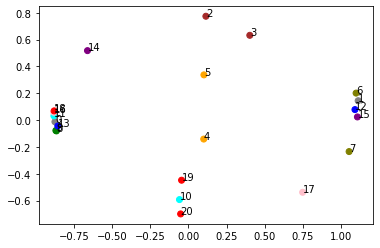

In [327]:
pca = PCA(n_components=2)
new_data_PCA = pca.fit_transform(vecs)

plt.scatter(new_data_PCA[:, 0], new_data_PCA[:, 1], c = range(len(vecs)),
        cmap=matplotlib.colors.ListedColormap(colors))

ax = plt.gca()
for i in range(len(new_data_PCA)):
    ax.annotate(str(i),(new_data_PCA[i, 0],new_data_PCA[i, 1]))


In [328]:
def get_corresponding_color(id):
    return colors[id]

def cal_angle(v1,v2):
    return np.dot(v1,v2)/(np.linalg.norm(v1) * np.linalg.norm(v2))

def get_distance(plane1, plane2):
    n = len(plane1)
    res = 0
    for i in range(n):
        res += cal_angle(plane1[i], plane2[i])**2
    res /= n 
    return np.sqrt(res)



from sklearn.decomposition import PCA
# 利用协方差最大的方向进行降维
# 数据集: 降维后的维度
# return: 拟合平面的两个基向量组成的list
def PCA_fitting_plane(dataMat, topNfeat=2):
    dataMat = np.mat(dataMat)

    meanVals = np.mean(dataMat, axis=0)
    meanRemoved = dataMat - meanVals
    covMat = np.cov(meanRemoved, rowvar=0)  # 得到协方差矩阵

    # 得到基于协方差矩阵的特征值和特征向量（一列表示一个特征向量）
    eigVals, eigVects = np.linalg.eig(np.mat(covMat))
    eigValInd = np.argsort(eigVals)  # 对特征值进行排序（从小到大），返回其对应的数组索引（按从小到大顺序）
    # 从排序后的矩阵最后一个开始自下而上选取最大的N个特征值，返回其对应的数组索引
    eigValInd = eigValInd[:-(topNfeat + 1):-1]
    redEigVects = eigVects[:, eigValInd]  # 从特征向量数组中取出特征值较大的特征向量组成数组
    # lowDDataMat = meanRemoved * redEigVects  # 将去除均值后的数据矩阵*压缩矩阵，转换到新的空间，使维度降低为N
    # 返回压缩后的数据矩阵即该矩阵反构出原始数据矩阵
    return redEigVects


def get_dist_to_plain(plain, v):
    length = int(len(plain)/2)
    v1, v2 = plain[0:length], plain[length:]
    new_v = np.dot(np.dot(v1, v), v1) + np.dot(np.dot(v2, v), v2)
    return np.linalg.norm(v-new_v)
    
    
def get_fitted_plain(vecs):
    if len(vecs) == 2:
        axis1, axis2 = vecs[0], vecs[1]

        axis1 = normalize(axis1)
        a = 1
        axis1_length = 1
        b = -a / np.dot(axis2, axis1)
        axis2 = normalize(a*axis1+b*axis2)
        plain = np.array([axis1, axis2])
        print('dists-->',np.sum([get_dist_to_plain(plain, feature) for feature in vecs]))
        return np.array([axis1, axis2])

    length = len(vecs[0])

    def fun(P):

        dists = np.sum([get_dist_to_plain(P, v) for v in vecs])
        return dists

    ans = fmin(fun, np.array([normalize(np.random.random(length)), normalize(
        np.random.random(length))]), maxfun=100000)

    axis1, axis2 = ans[0:length], ans[length:]
    plain = np.array([axis1, axis2])

    axis1 = normalize(axis1)
    a = 1
    b = -a / np.dot(axis2, axis1)
    axis2 = normalize(a*axis1+b*axis2)

    plain = np.array([axis1, axis2])
    print('dists-->',
          np.sum([get_dist_to_plain(plain, feature) for feature in vecs]))
    return plain

# def get_all_planes(vecs, id_pair):
#     planes = []
#     pid_planes = {}
#     pid_labels = {}
#     pid = 0
#     for i in range(len(vecs)):
#         for j in range(i + 1, len(vecs)):
#             plane = get_fitted_plain([vecs[i], vecs[j]])
#             planes.append(plane)
#             pid_labels[pid] = list(set([id_pair[i][0], id_pair[i][1], id_pair[j][0], id_pair[j][1]]))
#             pid_planes[pid] = [vecs[i], vecs[j]]
#             pid += 1
    
#     return planes, pid_labels, pid_planes


def get_all_planes(vecs, id_pair):
    planes = []
    pid_vids = {}
    pid_labels = {}
    pid = 0
    for i in range(len(vecs)):
        for j in range(i + 1, len(vecs)):
            plane = get_fitted_plain([vecs[i], vecs[j]])
            print(plane)
            planes.append(plane)
            pid_labels[pid] = list(set([id_pair[i][0], id_pair[i][1], id_pair[j][0], id_pair[j][1]]))
            pid_vids[pid] = [i, j]
            pid += 1
    
    return planes, pid_labels, pid_vids

In [329]:
planes, pid_labels, pid_vids = get_all_planes(vecs, id_pair)

dists--> 1.6973602391360644e-15
[[ 5.78571872e-03 -1.87781399e-03  2.25670534e-02  8.06898257e-04
   1.16014998e-01  1.71589438e-02  2.74105337e-02  6.65706859e-02
  -1.31541809e-03 -8.56132160e-04 -9.82126553e-01  1.26258240e-01]
 [ 1.27977501e-02 -9.48674910e-02  2.76549696e-01  3.97299258e-03
   5.21425397e-01 -4.80231352e-02  2.16131375e-02  2.78240651e-01
  -1.03083568e-02 -4.90591708e-03  1.80404502e-01  7.27728720e-01]]
dists--> 7.9816133357664e-17
[[ 5.78571872e-03 -1.87781399e-03  2.25670534e-02  8.06898257e-04
   1.16014998e-01  1.71589438e-02  2.74105337e-02  6.65706859e-02
  -1.31541809e-03 -8.56132160e-04 -9.82126553e-01  1.26258240e-01]
 [-3.57425690e-01  1.74395102e-01  4.00962790e-02  2.45377445e-02
  -4.44383444e-01  7.66044280e-01  6.22871491e-02 -1.12127399e-02
   4.38746057e-03  1.10153339e-01 -1.43565172e-02  1.97378812e-01]]
dists--> 1.5540184672844548e-16
[[ 5.78571872e-03 -1.87781399e-03  2.25670534e-02  8.06898257e-04
   1.16014998e-01  1.71589438e-02  2.741053

<ipython-input-330-c9e97e706a23>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([axis1, axis2, [0, 0, 1]])


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

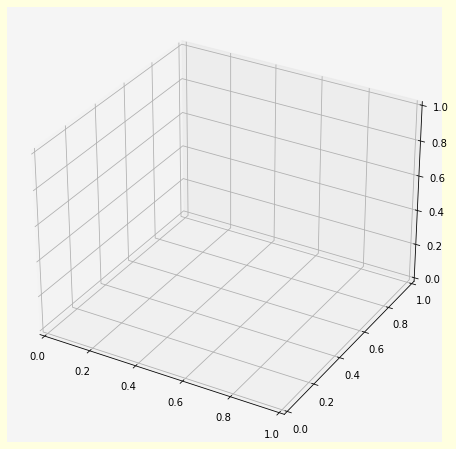

In [330]:


# 创建画布
fig = plt.figure(figsize=(12, 8),
                 facecolor='lightyellow'
                )

# 创建 3D 坐标系
ax = fig.gca(fc='whitesmoke',
             projection='3d' 
            )
# 二元函数定义域
x = np.linspace(0, 9, 5)
y = np.linspace(0, 9, 5)
X, Y = np.meshgrid(x, y)


# -------------------------------- 绘制 3D 图形 --------------------------------
i = 0
for plane in planes:
      axis1 = plane[0]
      axis2 = plane[1]
      A = np.array([axis1, axis2, [0, 0, 1]])
      b = np.array([0, 0, 1])
      r = np.linalg.solve(A,b)
      c1, c2, c3 = r[0], r[1], r[2]
      
      ax.plot_surface(X,
                Y,
                Z=(-c1*X-c2*Y)/c3,
                color=get_corresponding_color(i%10),
                alpha=0.6
               )
      i += 1
      
# --------------------------------  --------------------------------

# 设置坐标轴标题和刻度
ax.set(xlabel='X',
       ylabel='Y',
       zlabel='Z',
       xlim=(0, 9),
       ylim=(0, 9),
       zlim=(0, 9),
       xticks=np.arange(0, 10, 2),
       yticks=np.arange(0, 10, 1),
       zticks=np.arange(0, 10, 1)
      )

# 调整视角
ax.view_init(elev=15,    # 仰角
             azim=10   # 方位角
            )
     
# 显示图形
plt.show()

# HCluster

In [331]:
class Hierarchical:
    def __init__(self, center, left=None, right=None, vec_ids=None, flag=None, distance=0.0):
        self.center = center # 记录的是 plane (axis1, axis2) 保证正交
        self.left = left
        
        self.right = right
        self.vec_ids = vec_ids
        self.flag = flag
        self.distance = distance


def traverse_id(node):
    if node.left == None and node.right == None:
        return [node.flag]
    else:
        return traverse_id(node.left)+traverse_id(node.right)

    



# data=[plane1, plane2, ..., plane3]
# plane =[v1id, v2id]

# clusters = [clu1, clu2, ...]
# clu = [vec1id, vec2id, ...]
# center = [vec1, vec2]


def hcluster(data, n):
    if len(data) <= 0:
        print('invalid data')
    # 初始化每一点为一个簇
    clusters = [Hierarchical(center=data[i], vec_ids=pid_vids[i], flag=i) for i in range(len(data))]
    # 距离字典
    distances = {}
    min_id1 = None
    min_id2 = None
    current_cluster = -1
    maxv = int(1e9)

    while len(clusters) > n:
        min_dist = maxv
        
        for i in range(len(clusters)-1):
            for j in range(i+1, len(clusters)):
                # 计算两两簇之间的距离
                if distances.get((clusters[i], clusters[j])) == None:
                    distances[(clusters[i].flag, clusters[j].flag)] = get_distance(
                        clusters[i].center, clusters[j].center)

                # 如果距离小于目前遇到的最小距离
                # 记录这两个簇ID以及最小距离
                if distances[(clusters[i].flag, clusters[j].flag)] <= min_dist:
                    min_id1 = i
                    min_id2 = j
                    min_dist = distances[(clusters[i].flag, clusters[j].flag)]

        # 如果存在最小距离
        if min_id1 != None and min_id2 != None and min_dist != maxv:
            # 则把这两个ID对应的簇合并
            vec_ids = [v for v in clusters[min_id1].vec_ids] + [v for v in clusters[min_id2].vec_ids]
            vec_ids = list(set(vec_ids))
            print(vec_ids)
            vecs = [id_vecs[vid] for vid in vec_ids]
            new_center = get_fitted_plain(vecs)
            new_flag = current_cluster
            current_cluster -= 1
            new_cluster = Hierarchical(
                new_center, clusters[min_id1], clusters[min_id2], vec_ids, new_flag, min_dist)
            del clusters[min_id2]
            del clusters[min_id1]
            clusters.append(new_cluster)
        print('-'*50)
        # print(distances)

    final_cluster = [traverse_id(clusters[i]) for i in range(len(clusters))]
    return final_cluster


def get_cluster(planes, n):
    clusters = hcluster(planes, n)
    return clusters


def get_proj_set_and_label(clusters):
    proj_labels = []
    proj_set = []
    for clu in clusters:
        ids = clu
        labels = [pid_labels[i][j] for i in ids for j in range(len(pid_labels[i]))]
        proj_labels.append(np.array(list(set(labels))))

        vids = list(set([pid_vids[i][j] for i in ids for j in range(len(pid_vids[i]))]))
        print('vids: ', vids)
        vecs = [id_vecs[i] for i in vids]
        proj_set.append(get_fitted_plain(vecs))
    return proj_labels, proj_set

In [332]:
clusters = get_cluster(planes, n=3)
clusters

[2, 11, 12]
Optimization terminated successfully.
         Current function value: 0.972190
         Iterations: 10758
         Function evaluations: 13256
dists--> 0.967500794275766
--------------------------------------------------
[2, 11, 13, 15]
Optimization terminated successfully.
         Current function value: 1.003040
         Iterations: 14109
         Function evaluations: 17389
dists--> 0.9745135938708176
--------------------------------------------------
[2, 11, 13, 15]
Optimization terminated successfully.
         Current function value: 1.338268
         Iterations: 9764
         Function evaluations: 12161
dists--> 1.3382646174519586
--------------------------------------------------
[16, 11, 4]
Optimization terminated successfully.
         Current function value: 1.024914
         Iterations: 3361
         Function evaluations: 4239
dists--> 1.017416368097617
--------------------------------------------------
[1, 13, 12, 5]
Optimization terminated successfully.
    

In [ ]:
proj_labels, proj_set = get_proj_set_and_label(clusters)

vids:  [0, 4]
dists--> 2.981635874157676e-16
vids:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Optimization terminated successfully.
         Current function value: 5.459049
         Iterations: 16963
         Function evaluations: 20652
dists--> 5.446544775474288
vids:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Optimization terminated successfully.
         Current function value: 5.814275
         Iterations: 13774
         Function evaluations: 16779
dists--> 5.808150089076392


In [ ]:
def project_on_merged_vectors(data, label, plot_class_set, axis1, axis2, ax=None):
    '''
        axis?: 一个向量集所对应的box区域的交集部分的中心向量
        set? : axis?所对应的向量集所能区分的labels
    '''
    data_0 = []
    data_1 = []
    label_ = []
    for it in set(plot_class_set):
        x = np.dot(data[label == it], axis1)
        if it in plot_class_set:
            data_0.extend(list(x))
        
        if len(axis2):
            y = np.dot(data[label == it], axis2)
            if it in plot_class_set:
                data_1.extend(list(y))
            
        if it in plot_class_set:
            label_.extend([it]*len(x))
        
        if ax:
            if it in plot_class_set:
                ax.scatter(x, y, color=get_corresponding_color(it), label=str(it), alpha=1, s=10)
            else:
                ax.scatter(x, y, color=get_corresponding_color(it), label=str(it), alpha=0.1, s=10)
                
    if ax:
        ax.legend(loc='center left', bbox_to_anchor=(0.2, 1.12),ncol=3)
    
    if len(axis2) == 0:
        data_1 = [0 for _ in range(len(data_0))]
        
    data_ = np.vstack([data_0,data_1]).T
    label_ = np.array(label_)
    return data_0, data_1, data_, label_   
    


In [ ]:
def draw_projection(proj_set, data, label, vecs_label):
    plot_tot = int(len(proj_set))

    # 投影后的点的矩阵的shape
    row_num = int(np.ceil(plot_tot / 2.0))
    col_num = 2     # 列数=总图数/行数

    fig, ax = plt.subplots(nrows=row_num, ncols=col_num, squeeze=False, figsize=(10, 10))

    pos = 0 

    # 对每一个图
    for i in range(row_num):
        for j in range(col_num):
            proj = proj_set[pos]
            sep_labels = [i for i in vecs_label[pos]]
            print(sep_labels)
            project_on_merged_vectors(data, label, sep_labels, proj[0], proj[1], ax[i][j])
            pos += 1
            if pos == plot_tot:
                break
        if pos == plot_tot:
                break

    plt.tight_layout()
        

[0, 1, 2]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


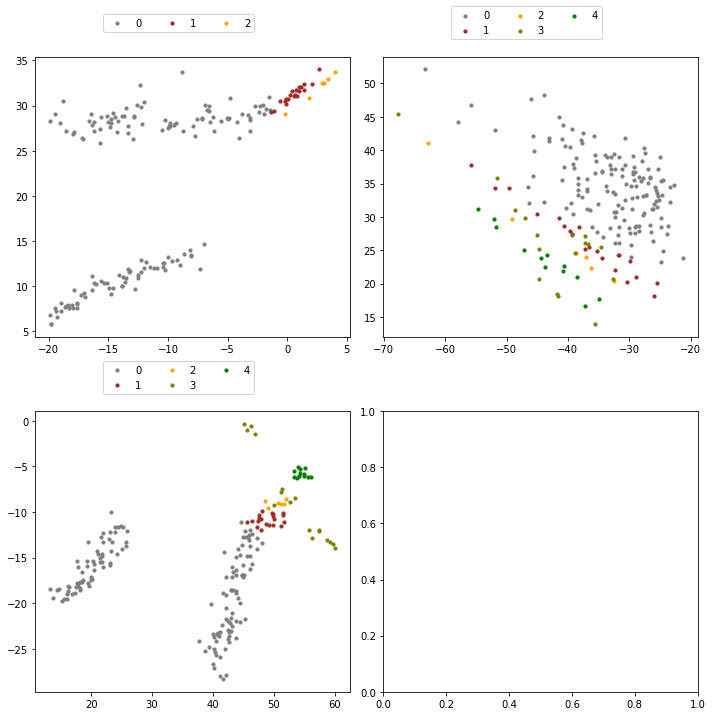

In [ ]:
draw_projection(proj_set, data, label, proj_labels)

In [ ]:
get_weighted_GONG(data, label, proj_set, proj_labels)

{0: 0.9908045977011494, 1: 0.825, 2: 0.6666666666666666}
{0: 0.9550574712643679, 1: 0.46416666666666656, 2: 0.16666666666666666, 3: 0.3235294117647059, 4: 0.6944444444444443}
{0: 0.9857471264367816, 1: 0.8541666666666666, 2: 0.611111111111111, 3: 0.8382352941176471, 4: 1.0}
-------
{0: 0.9908045977011494, 1: 0.8541666666666666, 2: 0.6666666666666666, 3: 0.8382352941176471, 4: 1.0}
{0: 145, 1: 20, 2: 6, 3: 17, 4: 12}


0.955

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [ ]:
def test_lda(data, label):
    clf = LDA(n_components=2)
    new_data_LDA = clf.fit_transform(data, label)
    plt.scatter(new_data_LDA[:, 0], new_data_LDA[:, 1], c=label,
            cmap=matplotlib.colors.ListedColormap(colors))

    GONG = get_GONG_value(new_data_LDA, label, 'test')
    plt.title('LDA: ' + str(round(GONG, 4)))
    
#     plt.savefig('./result/' + fname + '/' + fname.split('.')[0] + '_LDA.png')
    plt.show()
    
    return GONG

In [ ]:
def test_pca(data, label):
    pca = PCA(n_components=2)
    new_data_PCA = pca.fit_transform(data)

    plt.scatter(new_data_PCA[:, 0], new_data_PCA[:, 1], c=label,
            cmap=matplotlib.colors.ListedColormap(colors))

    GONG = get_GONG_value(new_data_PCA, label, 'test')
    plt.title('PCA: ' + str(round(GONG, 4)))
    
#     plt.savefig('./result/' + fname + '/' + fname.split('.')[0] + '_PCA.png')

    plt.show()
    return GONG

In [ ]:
def test_tsne(data, label):
    sc = StandardScaler()
    data_std = sc.fit_transform(data)

    tsne = TSNE(n_components=2, learning_rate=100)
    new_data_tsne = tsne.fit_transform(data)

    plt.scatter(new_data_tsne[:, 0], new_data_tsne[:, 1], c=label,
            cmap=matplotlib.colors.ListedColormap(colors))

    GONG = get_GONG_value(new_data_tsne, label, 'test')
    plt.title('t-SNE: ' + str(round(GONG, 4)))
    
#     plt.savefig('./result/' + fname + '/' + fname.split('.')[0] + '_TSNE.png')

    plt.show()
    return GONG

In [ ]:
def test_kda(data, label):
    kda = KernelDiscriminantAnalysis()
    a = kda.fit(data, label)
    b = kda.transform(data)
    new_data_KDA = kda.fit_transform(data,label)
    plt.scatter(new_data_KDA[:,0],new_data_KDA[:,1],c=label,cmap = matplotlib.colors.ListedColormap(colors))
    GONG = get_GONG_value(new_data_KDA, label, 'test')
    plt.title('KDA: ' + str(round(GONG, 4)))
    plt.show()
    
#     plt.savefig('./result/' + fname + '/' + fname.split('.')[0] + '_KDA.png')
    return GONG

In [170]:
"""
Scikit-learn-compatible Kernel Discriminant Analysis.

Used in
David Diaz-Vico, Jose R. Dorronsoro
"Deep vs Kernel Fisher Discriminant Analysis"

Based on algorithm 5 in
Zhihua Zhang, Guang Dai, Congfu Xu, Michael I. Jordan
"Regularized Discriminant Analysis, Ridge Regression and Beyond"
http://www.jmlr.org/papers/v11/zhang10b.html

,author: David Diaz Vico
,license: MIT
"""

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics.pairwise import (chi2_kernel, laplacian_kernel,
                                      linear_kernel, polynomial_kernel,
                                      rbf_kernel, sigmoid_kernel)
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
from sklearn.datasets import make_classification
from scipy.sparse import csc_matrix, csr_matrix

class KernelDiscriminantAnalysis(BaseEstimator, ClassifierMixin,
                                 TransformerMixin):
    """Kernel Discriminant Analysis.

    Parameters
    ----------
    lmb: float (>= 0.0), default=0.001
         Regularization parameter
    kernel: {"chi2", "laplacian", "linear", "polynomial", "rbf", "sigmoid"},
            default='rbf'
            Kernel.
    degree: integer, default=3
    gamma: float, default=None
    coef0: integer, default=1

    """

    def __init__(self, lmb=0.001, kernel='rbf', degree=3, gamma=None, coef0=1):
        self.lmb = lmb
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0

    def _kernel(self, X, Y=None):
        """Kernel"""
        kernel = None
        if self.kernel == 'chi2':
            kernel = chi2_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'laplacian':
            kernel = laplacian_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'linear':
            kernel = linear_kernel(X, Y)
        elif self.kernel == 'polynomial':
            kernel = polynomial_kernel(X, Y, degree=self.degree,
                                       gamma=self.gamma, coef0=self.coef0)
        elif self.kernel == 'rbf':
            kernel = rbf_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'sigmoid':
            kernel = sigmoid_kernel(X, Y, gamma=self.gamma, coef0=self.coef0)
        return kernel

    def fit(self, X, y):
        """Fit KFDA model.

        Parameters
        ----------
        X: numpy array of shape [n_samples, n_features]
           Training set.
        y: numpy array of shape [n_samples]
           label values. Only works for 2 classes.

        Returns
        -------
        self

        """
        n = len(X)
        self._X = X
        self._H = np.identity(n) - np.matmul(1. / n * np.ones(n), np.ones(n).T) #np.ones(n) , np.ones(n).T
        self._E = OneHotEncoder().fit_transform(y.reshape(n, 1))
        _, counts = np.unique(y, return_counts=True)
        K = self._kernel(X)
        C = np.matmul(np.matmul(self._H, K), self._H)
        self._Delta = np.linalg.inv(C + self.lmb * np.identity(n))
        A = np.matmul(csc_matrix.toarray(self._E.T), C)
        B = np.matmul(self._Delta , csr_matrix.toarray(self._E))
        self._Pi_12 = np.diag(np.sqrt(1.0 / counts))
        P = np.matmul(self._Pi_12 , A)
        Q = np.matmul(B , self._Pi_12)
        R = np.matmul(P, Q)
        V, self._Gamma, self._U = np.linalg.svd(R, full_matrices=False)
        return self

    def transform(self, X):
        """Transform data with the trained KFDA model.

        Parameters
        ----------
        X: numpy array of shape [n_samples, n_features]
           The input data.

        Returns
        -------
        y_pred: array-like, shape (n_samples, labels_shape)
                Transformations for X.

        """
        _K = self._kernel(X, self._X)
        K = _K - np.mean(_K, axis=0)
        C = np.matmul(self._H, K.T)
        x = np.matmul(np.matmul(self._U, self._Pi_12), csc_matrix.toarray(self._E.T))
        T = np.matmul(x,self._Delta)
        Z = np.matmul(T, C)
        return Z.T

In [171]:
def run_all(fname, n_cluster):
    # get the data
    data, label = read_data_from_file(fname)
    # data, label = X, y
    label = get_label_right(label)
    label = np.array(list(map(int, label)))
    print(data.shape)
    print(label)
    print('+'*80)
    # get the cluster
    vec_dict, vecs = get_between_class_opt_vec(data, label)
    id_pair, id_vecs = get_id_pair(vec_dict)
    clusters = get_cluster(planes, n=3)
    # get the projection
    proj_labels, proj_set = get_proj_set_and_label(clusters)
    draw_projection(proj_set, data, label, proj_labels)
    score = get_weighted_GONG(data, label, proj_set, proj_labels)
    print(score)
    return score

## Total

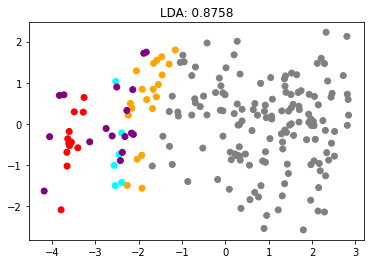

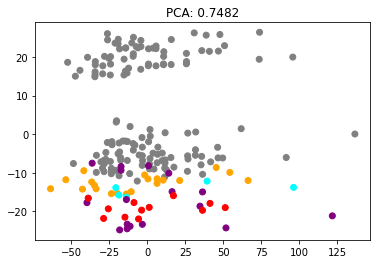

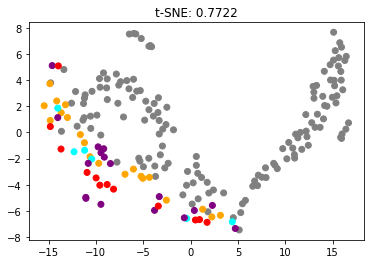

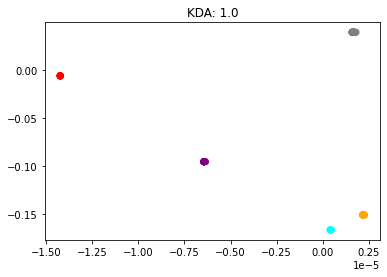

1.0

In [ ]:
# fname = 'world_9d.csv'
# data, label = read_data_from_file(fname)
# run_all(fname, 4)
test_lda(data, label)
test_pca(data, label)
test_tsne(data, label)
test_kda(data, label)

In [ ]:
run_all(fname, 4)

(151, 10)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4]
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


NameError: name 'get_cluster' is not defined

In [ ]:
run_on_all_file()

In [ ]:
def test_threshold(fname, measure_option = "dDSC"):
    thresholds = list(np.linspace(0.9, 0.8, 10))
    GONG_list = []
    for threshold in thresholds:
        stime = time.time()
        weighted_GONG = run_all(fname=fname, threshold=threshold)
#         GONG_list.append(weighted_GONG)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    plt.plot(thresholds, GONG_list)
    
    return GONG_list

In [ ]:
test_threshold(fname='world_9d.csv')

In [ ]:
#2个类的文件都要踢出来
path = r'.\Data'
dirs = os.listdir(path)
for fname in dirs:
    data, label = read_data_from_file(fname)
    if(len(set(label)) == 2):
        print(fname)